In [1]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings('ignore')

seconds_per_day=60.*60.*24.
seconds_per_year=365.*seconds_per_day
carbon_molar_mass=12.011
cobalt_n_2_c = 106./16.

In [2]:
ctrl={}
case={}

ctrl['path_root']='/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT'
ctrl['machine_target']='gfdl.ncrc4-intel19-prod'
ctrl['name']='OM4p5_CORE2_IAF_gzCOBALT-013022_cy5'

case['path_root']='/archive/Jessica.Luo/gz_test/MOM6_SIS2_gzCOBALTv2'
case['machine_target']='gfdl.ncrc4-intel19-prod'
case['name']='OM4p5_CORE2_IAF_gzCOBALT-tun_cy5'
#case['name']='OM4p5_CORE2_IAF_gzCOBALT-tun_hp_cy5'
case['name']='OM4p5_CORE2_IAF_gzCOBALT-hp_cy5'

In [3]:
if 'hp' in case['name']:
    hp_det_is_fast=True
else:
    hp_det_is_fast=False

In [4]:
short_casename=case['name'].replace('OM4p5_CORE2_IAF_','')
if short_casename=="gzCOBALT-060822":
    fig_casename='gzCOBALT-tun_cy1'
else:
    fig_casename=short_casename
print(short_casename, fig_casename)

gzCOBALT-hp_cy5 gzCOBALT-hp_cy5


In [5]:
phyto_varlist = ['di', 'smp', 'lgp']
zoo_varlist = ['smz', 'mdz', 'lgz', 'smt', 'lgt']

In [6]:
tmpdir = '/work/Jessica.Luo/tmp/'+case['name']
if not os.path.exists(tmpdir):
    os.mkdir(tmpdir)
    print('created directory: '+tmpdir)
else:
    print('temporary directory exists: '+tmpdir)

temporary directory exists: /work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-hp_cy5


In [7]:
# read in files
diagTypes = ['ocean_cobalt_omip_tracers_month_z', 'ocean_cobalt_omip_2d', \
             'ocean_cobalt_fluxes_int', 'ocean_cobalt_fdet_100', 'ocean_cobalt_tracers_int'] 

pp_dates='1988-2007'
#pp_dates='2048-2067'

files=[glob(tmpdir + '/'+ d + '.' + pp_dates + '*.nc') for d in diagTypes]

files=sorted([f for fi in files for f in fi]) # nested list comprehension


In [8]:
if not files:
    pp_path=os.path.join(case['path_root'], case['name'], case['machine_target'], 'pp')
    
    files=[glob(pp_path + '/' + d + '/av/monthly_5yr/' + d + '.' + pp_dates + '*.nc') for d in diagTypes]
    
    files=sorted([f for fi in files for f in fi]) # nested list comprehension
    print(files)


In [9]:
grid_file=os.path.join(case['path_root'], case['name'], case['machine_target'], 'pp')+'/ocean_annual/ocean_annual.static.nc'
ds=xr.open_mfdataset(files, combine='by_coords')
#grid=xr.open_dataset(grid_file)
grid = xr.open_dataset('/work/jyl/tmp/ocean_static.nc')

In [10]:
tmpdir = '/work/Jessica.Luo/tmp/'+ctrl['name']
if not os.path.exists(tmpdir):
    os.mkdir(tmpdir)
    print('created directory: '+tmpdir)
else:
    print('temporary directory exists: '+tmpdir)
    
# read in files
diagTypes = ['ocean_cobalt_omip_tracers_month_z', 'ocean_cobalt_omip_2d', \
             'ocean_cobalt_fluxes_int', 'ocean_cobalt_fdet_100', 'ocean_cobalt_tracers_int'] 

pp_dates='1988-2007'

c_files=[glob(tmpdir + '/'+ d + '.' + pp_dates + '*.nc') for d in diagTypes]

c_files=sorted([f for fi in c_files for f in fi]) # nested list comprehension

if not c_files:
    pp_path=os.path.join(ctrl['path_root'], ctrl['name'], ctrl['machine_target'], 'pp')
    
    c_files=[glob(pp_path + '/' + d + '/av/monthly_5yr/' + d + '.' + pp_dates + '*.nc') for d in diagTypes]
    
    c_files=sorted([f for fi in c_files for f in fi]) # nested list comprehension

#print(c_files)

temporary directory exists: /work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-013022_cy5


In [11]:
dc=xr.open_mfdataset(c_files, combine='by_coords')

In [12]:
ds['depth_levels']=xr.DataArray(ds.z_i.diff(dim='z_i').values, coords={'z_l':ds.z_l.values}, dims=['z_l'], attrs={'long_name':'Thickness of depth bin', 'units':'meters'})

In [13]:
[v for v in ds if 'jprod_ndet' in v]

['jprod_ndet_nsmz_100',
 'jprod_ndet_nmdz_100',
 'jprod_ndet_nlgz_100',
 'jprod_ndet_nsmt_100',
 'jprod_ndet_nlgt_100',
 'jprod_ndet_nlgt_fast_100',
 'jprod_ndet_hp_100']

# Plots

### Some plots of Detritus Production

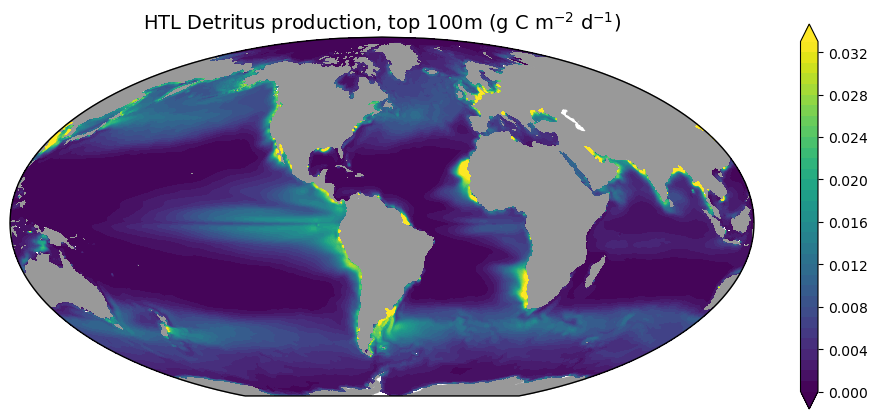

In [14]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Mollweide(central_longitude=300.0))

field=ds.jprod_ndet_hp_100.mean(dim='time')*cobalt_n_2_c*carbon_molar_mass*seconds_per_day

cs=ax.contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=np.arange(0,0.034,0.001), extend='both')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')

plt.colorbar(cs, extend='both')
plt.title('HTL Detritus production, top 100m (g C m$^{-2}$ d$^{-1}$)', fontsize=14)
plt.savefig('plots/'+fig_casename+'_'+pp_dates+'_HTL_det_prod.png', dpi=300, bbox_inches='tight')

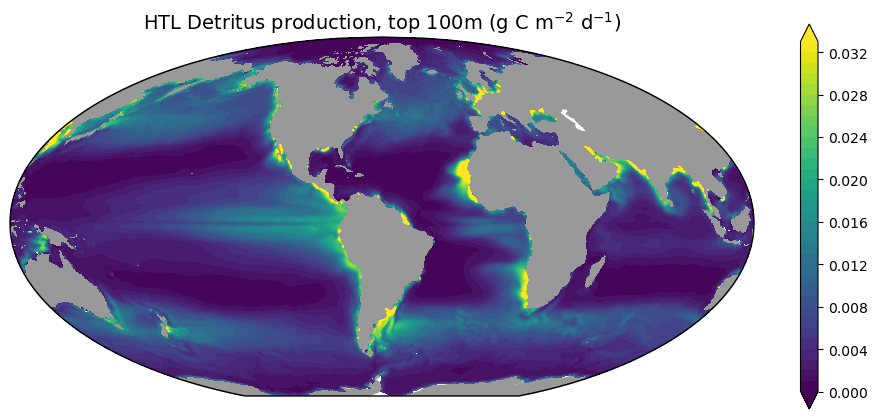

In [15]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Mollweide(central_longitude=300.0))

field=dc.jprod_ndet_hp_100.mean(dim='time')*cobalt_n_2_c*carbon_molar_mass*seconds_per_day

cs=ax.contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=np.arange(0,0.034,0.001), extend='both')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')

plt.colorbar(cs, extend='both')
plt.title('HTL Detritus production, top 100m (g C m$^{-2}$ d$^{-1}$)', fontsize=14)
plt.savefig('plots/'+ctrl['name'].replace('OM4p5_CORE2_IAF_','')+'_'+pp_dates+'_HTL_det_prod.png', dpi=300, bbox_inches='tight')

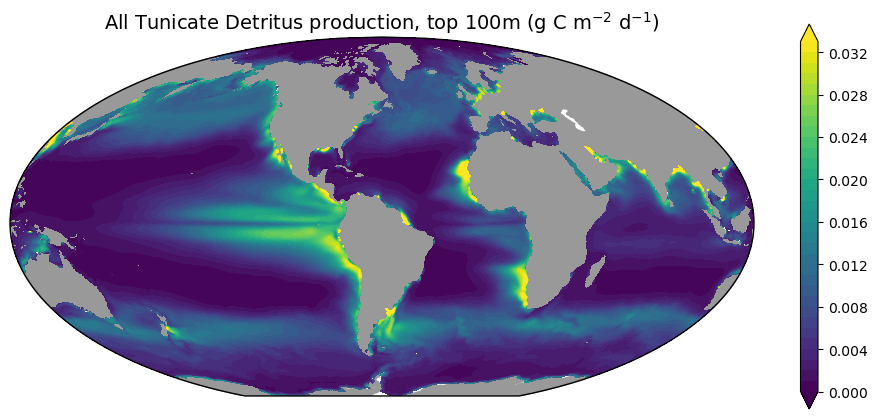

In [16]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Mollweide(central_longitude=300.0))

field=(ds.jprod_ndet_nsmt_100 + ds.jprod_ndet_nlgt_100 + ds.jprod_ndet_nlgt_fast_100).mean(dim='time')*cobalt_n_2_c*carbon_molar_mass*seconds_per_day

cs=ax.contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=np.arange(0,0.034,0.001), extend='both')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')

plt.colorbar(cs, extend='both')
plt.title('All Tunicate Detritus production, top 100m (g C m$^{-2}$ d$^{-1}$)', fontsize=14)
plt.savefig('plots/'+fig_casename+'_'+pp_dates+'_Tun_det_prod.png', dpi=300, bbox_inches='tight')

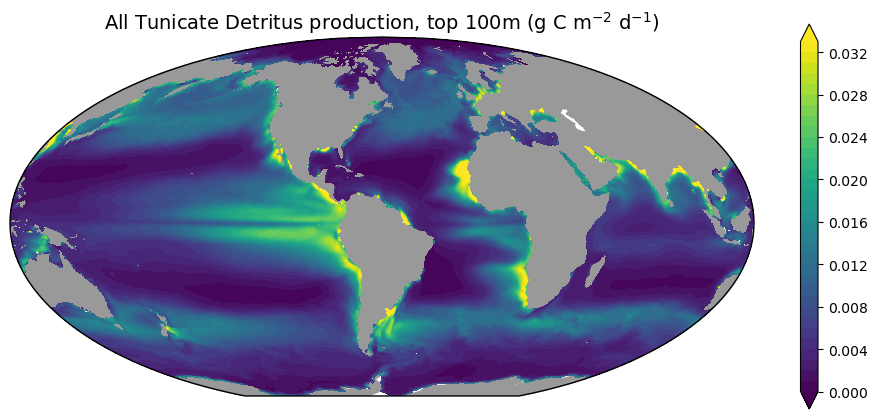

In [17]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Mollweide(central_longitude=300.0))

field=(dc.jprod_ndet_nsmt_100 + dc.jprod_ndet_nlgt_100).mean(dim='time')*cobalt_n_2_c*carbon_molar_mass*seconds_per_day

cs=ax.contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=np.arange(0,0.034,0.001), extend='both')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')

plt.colorbar(cs, extend='both')
plt.title('All Tunicate Detritus production, top 100m (g C m$^{-2}$ d$^{-1}$)', fontsize=14)
plt.savefig('plots/'+ctrl['name'].replace('OM4p5_CORE2_IAF_','')+'_'+pp_dates+'_Tun_det_prod.png', dpi=300, bbox_inches='tight')

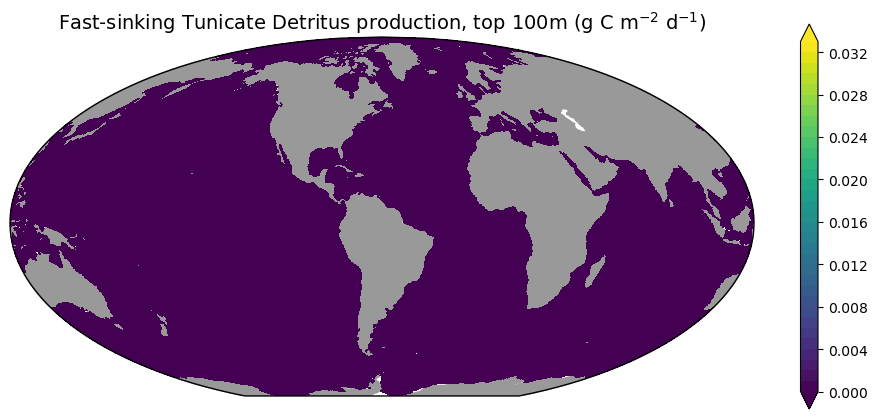

In [18]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Mollweide(central_longitude=300.0))

field=(ds.jprod_ndet_nlgt_fast_100).mean(dim='time')*cobalt_n_2_c*carbon_molar_mass*seconds_per_day

cs=ax.contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=np.arange(0,0.034,0.001), extend='both')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')

plt.colorbar(cs, extend='both')
plt.title('Fast-sinking Tunicate Detritus production, top 100m (g C m$^{-2}$ d$^{-1}$)', fontsize=14)
plt.savefig('plots/'+fig_casename+'_'+pp_dates+'_Tun_fastdet_prod.png', dpi=300, bbox_inches='tight')

### Some stats of Fast Sinking Detritus

In [19]:
if hp_det_is_fast:
    fast_det_prod = ds.jprod_ndet_nlgt_fast_100 + ds.jprod_ndet_hp_100
else:
    fast_det_prod = ds.jprod_ndet_nlgt_fast_100

In [20]:
concat_vars=[v for v in ds if 'jprod_ndet' in v]
concat_vars.extend([v for v in ds if 'jaggloss' in v])
print(concat_vars)
tot_det_prod = xr.concat([ds[v] for v in concat_vars], dim='var').sum(dim='var')

['jprod_ndet_nsmz_100', 'jprod_ndet_nmdz_100', 'jprod_ndet_nlgz_100', 'jprod_ndet_nsmt_100', 'jprod_ndet_nlgt_100', 'jprod_ndet_nlgt_fast_100', 'jprod_ndet_hp_100', 'jaggloss_nsmp_100', 'jaggloss_nlgp_100', 'jaggloss_nlgt_100']


In [21]:
val_tot_det_prod = (tot_det_prod.mean(dim='time') * grid.areacello).sum(dim=['xh','yh']) 
val_tot_det_prod = val_tot_det_prod * cobalt_n_2_c * carbon_molar_mass * seconds_per_day * 365
print('Total Detritus Production: ' + str(np.format_float_scientific(val_tot_det_prod.values,2)) + ' Pg C y-1')

Total Detritus Production: 7.73e+15 Pg C y-1


In [22]:
val_fast_det_prod = (fast_det_prod.mean(dim='time') * grid.areacello).sum(dim=['xh','yh']) 
val_fast_det_prod = val_fast_det_prod * cobalt_n_2_c * carbon_molar_mass * seconds_per_day * 365
print('Total Fast Detritus Production: ' + str(np.format_float_scientific(val_fast_det_prod.values,2)) + ' Pg C y-1')

Total Fast Detritus Production: 6.23e+14 Pg C y-1


In [23]:
print('Fraction of detritus production that is fast: ' + str(np.round(val_fast_det_prod.values/val_tot_det_prod.values * 100,1)) + '%')

Fraction of detritus production that is fast: 8.1%


In [24]:
# val_tot_export_flux = ((dc.fndet_100).mean(dim='time') * grid.areacello).sum(dim=['xh','yh']) 
# val_tot_export_flux = val_tot_export_flux * cobalt_n_2_c * carbon_molar_mass * seconds_per_day * 365
# print('Total Detritus Export at 100m (control): ' + str(np.format_float_scientific(val_tot_export_flux.values,2)) + ' Pg C y-1')

In [25]:
val_tot_export_flux = ((ds.fndet_100 + ds.fndet_fast_100).mean(dim='time') * grid.areacello).sum(dim=['xh','yh']) 
val_tot_export_flux = val_tot_export_flux * cobalt_n_2_c * carbon_molar_mass * seconds_per_day * 365
print('Total Detritus Export at 100m: ' + str(np.format_float_scientific(val_tot_export_flux.values,2)) + ' Pg C y-1')

Total Detritus Export at 100m: 5.75e+15 Pg C y-1


In [26]:
val_fast_export_flux = (ds.fndet_fast_100.mean(dim='time') * grid.areacello).sum(dim=['xh','yh']) 
val_fast_export_flux = val_fast_export_flux * cobalt_n_2_c * carbon_molar_mass * seconds_per_day * 365
print('Total Fast Detritus Export at 100m: ' + str(np.format_float_scientific(val_fast_export_flux.values,2)) + ' Pg C y-1')

Total Fast Detritus Export at 100m: 5.91e+14 Pg C y-1


In [27]:
print('Fraction of detritus flux at 100m that is fast: ' + str(np.round(val_fast_export_flux.values/val_tot_export_flux.values * 100,1)) + '%')

Fraction of detritus flux at 100m that is fast: 10.3%


### Some plots of Fast Sinking Detritus

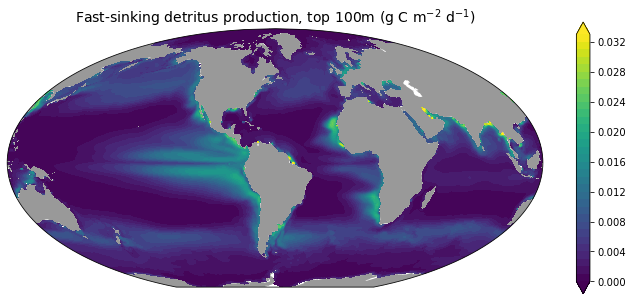

In [72]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Mollweide(central_longitude=300.0))

field=fast_det_prod.mean(dim='time')*cobalt_n_2_c*carbon_molar_mass*seconds_per_day

cs=ax.contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=np.arange(0,0.034,0.001), extend='both')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')

plt.colorbar(cs, extend='both')
plt.title('Fast-sinking detritus production, top 100m (g C m$^{-2}$ d$^{-1}$)', fontsize=14)
plt.savefig('plots/'+fig_casename+'_'+pp_dates+'_fast_ndet_prod.png', dpi=300, bbox_inches='tight')

In [73]:
#fraction of fast detritus production
frac_fast_det_prod = fast_det_prod/tot_det_prod

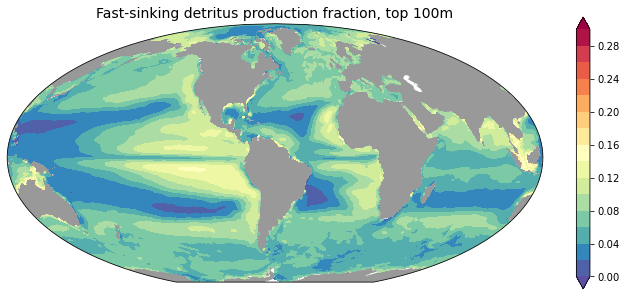

In [74]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Mollweide(central_longitude=300.0))

field=frac_fast_det_prod.mean(dim='time')

cs=ax.contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=np.arange(0,0.32,0.02), cmap='Spectral_r', extend='both')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')

plt.colorbar(cs, extend='both')
plt.title('Fast-sinking detritus production fraction, top 100m', fontsize=14)
plt.savefig('plots/'+fig_casename+'_'+pp_dates+'_Frac_fast_ndet_prod.png', dpi=300, bbox_inches='tight')

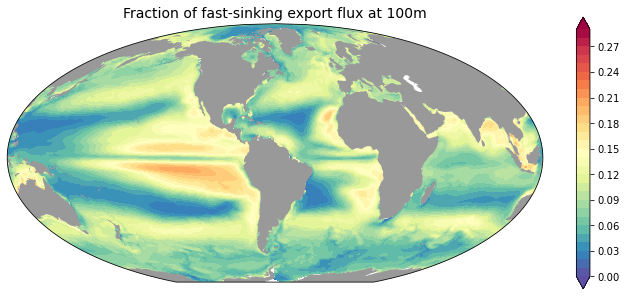

In [75]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Mollweide(central_longitude=300.0))

field= (ds.fndet_fast_100/(ds.fndet_fast_100 + ds.fndet_100)).mean(dim='time')

cs=ax.contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=np.arange(0,0.3,0.01), cmap='Spectral_r', extend='both')
ax.add_feature(cartopy.feature.LAND, zorder=1, facecolor='#999999')

plt.colorbar(cs, extend='both')
plt.title('Fraction of fast-sinking export flux at 100m', fontsize=14)
plt.savefig('plots/'+fig_casename+'_'+pp_dates+'_Frac_fast_export.png', dpi=300, bbox_inches='tight')

### Contrast against control

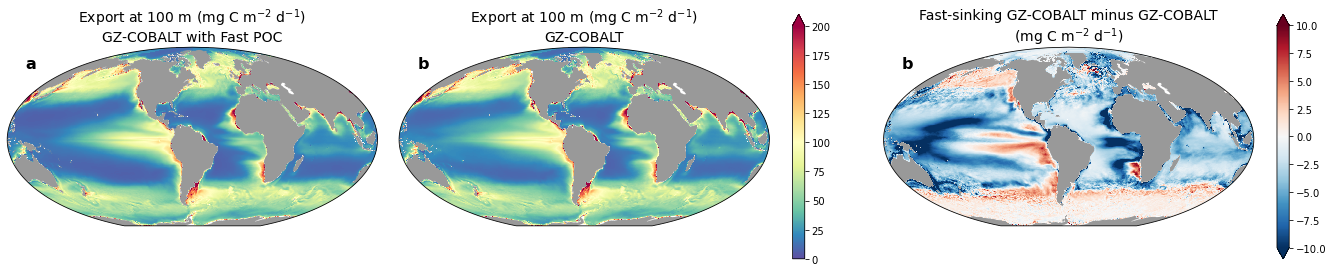

In [76]:
fig=plt.figure(figsize=(24,6))
gs=gridspec.GridSpec(1,3, wspace=0.05, width_ratios=[1,1.25,1.25])

ax={};cs={}


fastgz=((ds.fndet_fast_100 + ds.fndet_100).mean(dim='time')) * seconds_per_day * cobalt_n_2_c * carbon_molar_mass * 1e3
ctrlgz=dc.fndet_100.mean(dim='time') * seconds_per_day * cobalt_n_2_c * carbon_molar_mass * 1e3

i=0
field=fastgz
ax[i]=plt.subplot(gs[0,0],projection=ccrs.Mollweide(central_longitude=300.0))
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=0, vmax=200, cmap='Spectral_r')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='#999999')
ax[i].set_title('Export at 100 m (mg C m$^{-2}$ d$^{-1}$)\nGZ-COBALT with Fast POC', fontsize=14)

ax[i].text(0.05, 0.95, 'a', transform=ax[i].transAxes, fontsize=16, fontweight='bold', va='top')

i=1
field=ctrlgz
ax[i]=plt.subplot(gs[0,1],projection=ccrs.Mollweide(central_longitude=300.0))
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=0, vmax=200, cmap='Spectral_r')
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
ax[i].set_title('Export at 100 m (mg C m$^{-2}$ d$^{-1}$)\nGZ-COBALT', fontsize=14)
ax[i].text(0.05, 0.95, 'b', transform=ax[i].transAxes, fontsize=16, fontweight='bold', va='top')

plt.colorbar(cs[i], shrink=0.75, extend='max')

i=2
field=fastgz-ctrlgz
ax[i] = plt.subplot(gs[0,2],projection=ccrs.Mollweide(central_longitude=300.0))
cs[i]=ax[i].pcolormesh(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), vmin=-10, vmax=10, cmap='RdBu_r')
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
ax[i].set_title('Fast-sinking GZ-COBALT minus GZ-COBALT\n(mg C m$^{-2}$ d$^{-1}$)', fontsize=14)
ax[i].text(0.05, 0.95, 'b', transform=ax[i].transAxes, fontsize=16, fontweight='bold', va='top')

plt.colorbar(cs[i], shrink=0.75, extend='both')

plt.tight_layout()
plt.savefig('plots/'+fig_casename+'_'+pp_dates+'_ExportFlux_Comparison.png', dpi=300, bbox_inches='tight')
